In [2]:
#@title Setup. This will take a few minutes.
!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN
!pip install tqdm gdown scikit-learn==0.22 scipy lpips dlib opencv-python wandb
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from util import *
from PIL import Image
import math
import random
import os

import numpy as np
from torch import nn, autograd, optim
from torch.nn import functional as F
from tqdm import tqdm
import wandb
from model import *
from e4e_projection import projection as e4e_projection

from google.colab import files
from copy import deepcopy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

os.makedirs('inversion_codes', exist_ok=True)
os.makedirs('style_images', exist_ok=True)
os.makedirs('style_images_aligned', exist_ok=True)
os.makedirs('models', exist_ok=True)

Cloning into 'JoJoGAN'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 490 (delta 31), reused 31 (delta 31), pack-reused 450
Receiving objects: 100% (490/490), 63.51 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (203/203), done.
/content/JoJoGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 74.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 24.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s e

In [8]:
#@title Download models
#@markdown You may optionally enable downloads with pydrive in order to authenticate and avoid drive download limits.
download_with_pydrive = True #@param {type:"boolean"}    
device = 'cuda' #@param ['cuda', 'cpu']

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
%matplotlib inline


drive_ids = {
    "stylegan2-ffhq-config-f.pt": "1Yr7KuD959btpmcKGAUsbAk5rPjX2MytK",
    "e4e_ffhq_encode.pt": "1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7",
    "restyle_psp_ffhq_encode.pt": "1nbxCIVw9H3YnQsoIPykNEFwWJnHVHlVd",
    "arcane_caitlyn.pt": "1gOsDTiTPcENiFOrhmkkxJcTURykW1dRc",
    "arcane_caitlyn_preserve_color.pt": "1cUTyjU-q98P75a8THCaO545RTwpVV-aH",
    "arcane_jinx_preserve_color.pt": "1jElwHxaYPod5Itdy18izJk49K1nl4ney",
    "arcane_jinx.pt": "1quQ8vPjYpUiXM4k1_KIwP4EccOefPpG_",
    "arcane_multi_preserve_color.pt": "1enJgrC08NpWpx2XGBmLt1laimjpGCyfl",
    "arcane_multi.pt": "15V9s09sgaw-zhKp116VHigf5FowAy43f",
    "sketch_multi.pt": "1GdaeHGBGjBAFsWipTL0y-ssUiAqk8AxD",
    "disney.pt": "1zbE2upakFUAx8ximYnLofFwfT8MilqJA",
    "disney_preserve_color.pt": "1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi",
    "jojo.pt": "13cR2xjIBj8Ga5jMO7gtxzIJj2PDsBYK4",
    "jojo_preserve_color.pt": "1ZRwYLRytCEKi__eT2Zxv1IlV6BGVQ_K2",
    "jojo_yasuho.pt": "1grZT3Gz1DLzFoJchAmoj3LoM9ew9ROX_",
    "jojo_yasuho_preserve_color.pt": "1SKBu1h0iRNyeKBnya_3BBmLr4pkPeg_L",
    "art.pt": "1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT",
}

# from StyelGAN-NADA
class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_name):
        file_dst = os.path.join('models', file_name)
        file_id = drive_ids[file_name]
        if not os.path.exists(file_dst):
            print(f'Downloading {file_name}')
            if self.use_pydrive:
                downloaded = self.drive.CreateFile({'id':file_id})
                downloaded.FetchMetadata(fetch_all=True)
                downloaded.GetContentFile(file_dst)
            else:
                !gdown --id $file_id -O $file_dst



downloader = Downloader(download_with_pydrive)

downloader.download_file('stylegan2-ffhq-config-f.pt')
downloader.download_file('e4e_ffhq_encode.pt')

latent_dim = 512

# Load original generator
original_generator = Generator(1024, latent_dim, 8, 2).to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
original_generator.load_state_dict(ckpt["g_ema"], strict=False)
mean_latent = original_generator.mean_latent(10000)

# to be finetuned generator
generator = deepcopy(original_generator)


transform = transforms.Compose(
    [
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

--2023-05-17 19:38:08--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.2’

shape_predictor_68_ 100%[===================>]  61.07M  26.8MB/s    in 2.3s    

2023-05-17 19:38:11 (26.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.2’ saved [64040097/64040097]



Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


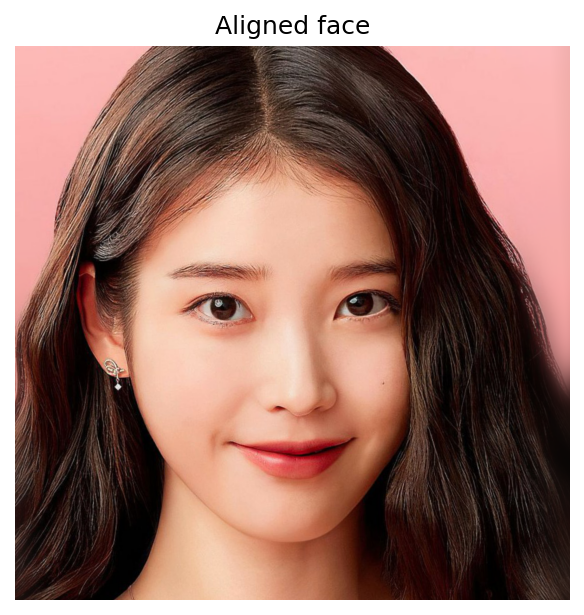

In [9]:
plt.rcParams['figure.dpi'] = 150

#@title Choose input face
#@markdown Add your own image to the test_input directory and put the name here
filename = 'iu.jpeg' #@param {type:"string"}
filepath = f'test_input/{filename}'

# uploaded = files.upload()
# filepath = list(uploaded.keys())[0]
name = strip_path_extension(filepath)+'.pt'

# aligns and crops face
aligned_face = align_face(filepath)

# my_w = restyle_projection(aligned_face, name, device, n_iters=1).unsqueeze(0)
my_w = e4e_projection(aligned_face, name, device).unsqueeze(0)

display_image(aligned_face, title='Aligned face')

/content/JoJoGAN/op/conv2d_gradfix.py:88: UserWarning: conv2d_gradfix not supported on PyTorch 2.0.0+cu118. Falling back to torch.nn.functional.conv2d().
  warnings.warn(


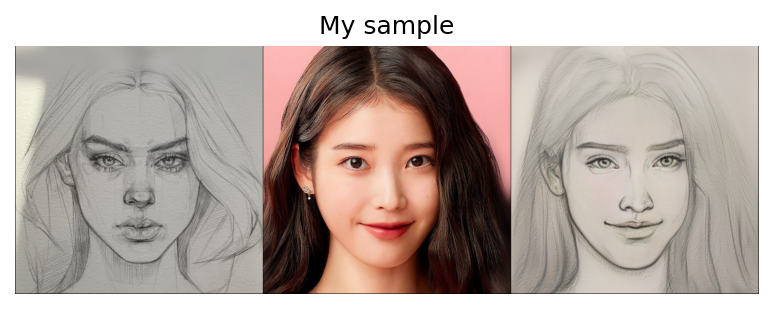

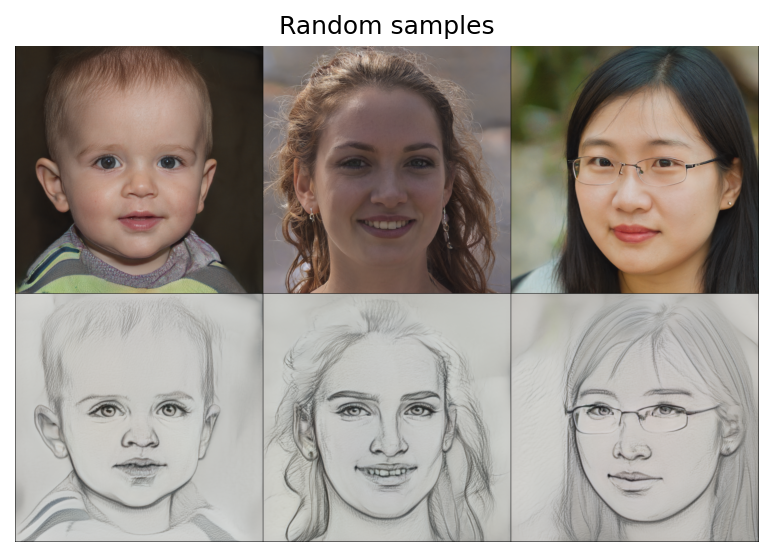

In [10]:
plt.rcParams['figure.dpi'] = 150
pretrained = 'sketch_multi' #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney']
#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = True #@param{type:"boolean"}

if preserve_color:
    ckpt = f'{pretrained}_preserve_color.pt'
else:
    ckpt = f'{pretrained}.pt'

# load base version if preserve_color version not available
try:
    downloader.download_file(ckpt)
except:
    ckpt = f'{pretrained}.pt'
    downloader.download_file(ckpt)

ckpt = torch.load(os.path.join('models', ckpt), map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt["g"], strict=False)

#@title Generate results
n_sample =  3#@param {type:"number"}
seed = 1000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
if pretrained == 'arcane_multi':
    style_path = f'style_images_aligned/arcane_jinx.png'
elif pretrained == 'sketch_multi':
    style_path = f'style_images_aligned/sketch.png'
else:   
    style_path = f'style_images_aligned/{pretrained}.png'

style_image = transform(Image.open(style_path)).unsqueeze(0).to(device)
face = transform(aligned_face).unsqueeze(0).to(device)

my_output = torch.cat([style_image, face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt
Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


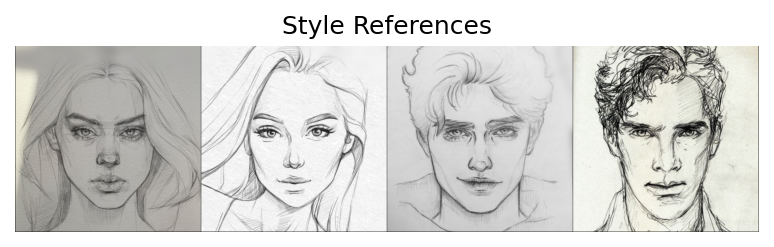

In [11]:
#@markdown Upload your own style images into the style_images folder and type it into the field in the following format without the directory name. Upload multiple style images to do multi-shot image translation
names = ['sketch.jpeg', 'sketch2.jpeg', 'sketch3.jpeg', 'sketch4.jpeg'] #@param {type:"raw"}

targets = []
latents = []

for name in names:
    style_path = os.path.join('style_images', name)
    assert os.path.exists(style_path), f"{style_path} does not exist!"

    name = strip_path_extension(name)

    # crop and align the face
    style_aligned_path = os.path.join('style_images_aligned', f'{name}.png')
    if not os.path.exists(style_aligned_path):
        style_aligned = align_face(style_path)
        style_aligned.save(style_aligned_path)
    else:
        style_aligned = Image.open(style_aligned_path).convert('RGB')

    # GAN invert
    style_code_path = os.path.join('inversion_codes', f'{name}.pt')
    if not os.path.exists(style_code_path):
        latent = e4e_projection(style_aligned, style_code_path, device)
    else:
        latent = torch.load(style_code_path)['latent']

    targets.append(transform(style_aligned).to(device))
    latents.append(latent.to(device))

targets = torch.stack(targets, 0)
latents = torch.stack(latents, 0)

target_im = utils.make_grid(targets, normalize=True, range=(-1, 1))
display_image(target_im, title='Style References')

In [12]:
#@title Finetune StyleGAN
#@markdown alpha controls the strength of the style
alpha = 0.7 #@param {type:"slider", min:0, max:1.01, step:0.1}
alpha = 1-alpha

#@markdown Tries to preserve color of original image by limiting family of allowable transformations. Set to false if you want to transfer color from reference image. This also leads to heavier stylization
preserve_color = True #@param{type:"boolean"}
#@markdown Number of finetuning steps. Different style reference may require different iterations. Try 200~500 iterations.
num_iter = 300 #@param {type:"number"}
#@markdown Log training on wandb and interval for image logging
use_wandb = False #@param {type:"boolean"}
log_interval = 50 #@param {type:"number"}

if use_wandb:
    wandb.init(project="JoJoGAN")
    config = wandb.config
    config.num_iter = num_iter
    config.preserve_color = preserve_color
    wandb.log(
    {"Style reference": [wandb.Image(transforms.ToPILImage()(target_im))]},
    step=0)

# load discriminator for perceptual loss
discriminator = Discriminator(1024, 2).eval().to(device)
ckpt = torch.load('models/stylegan2-ffhq-config-f.pt', map_location=lambda storage, loc: storage)
discriminator.load_state_dict(ckpt["d"], strict=False)

# reset generator
del generator
generator = deepcopy(original_generator)

g_optim = optim.Adam(generator.parameters(), lr=2e-3, betas=(0, 0.99))

# Which layers to swap for generating a family of plausible real images -> fake image
if preserve_color:
    id_swap = [9,11,15,16,17]
else:
    id_swap = list(range(7, generator.n_latent))

for idx in tqdm(range(num_iter)):
    mean_w = generator.get_latent(torch.randn([latents.size(0), latent_dim]).to(device)).unsqueeze(1).repeat(1, generator.n_latent, 1)
    in_latent = latents.clone()
    in_latent[:, id_swap] = alpha*latents[:, id_swap] + (1-alpha)*mean_w[:, id_swap]

    img = generator(in_latent, input_is_latent=True)

    with torch.no_grad():
        real_feat = discriminator(targets)
    fake_feat = discriminator(img)

    loss = sum([F.l1_loss(a, b) for a, b in zip(fake_feat, real_feat)])/len(fake_feat)
    
    if use_wandb:
        wandb.log({"loss": loss}, step=idx)
        if idx % log_interval == 0:
            generator.eval()
            my_sample = generator(my_w, input_is_latent=True)
            generator.train()
            my_sample = transforms.ToPILImage()(utils.make_grid(my_sample, normalize=True, range=(-1, 1)))
            wandb.log(
            {"Current stylization": [wandb.Image(my_sample)]},
            step=idx)

    g_optim.zero_grad()
    loss.backward()
    g_optim.step()

100%|██████████| 300/300 [10:38<00:00,  2.13s/it]


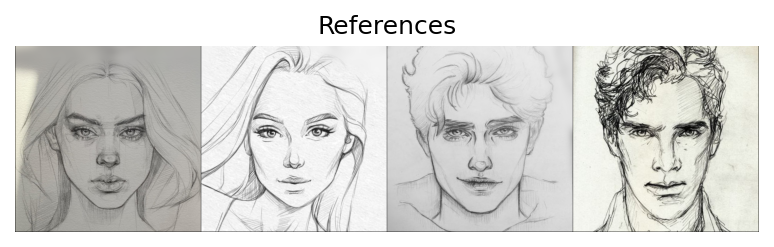

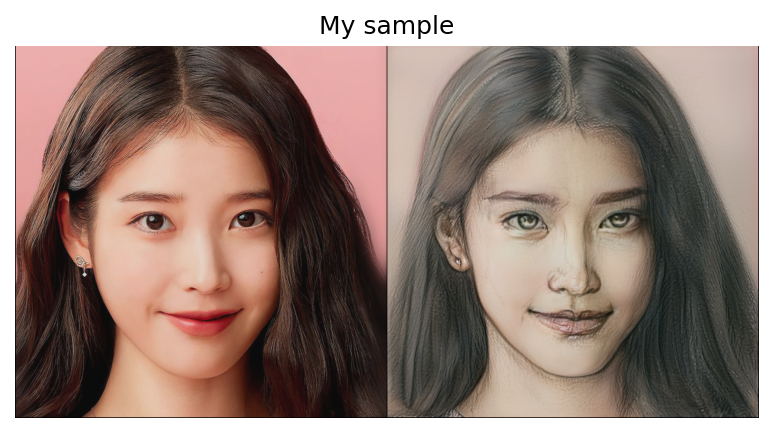

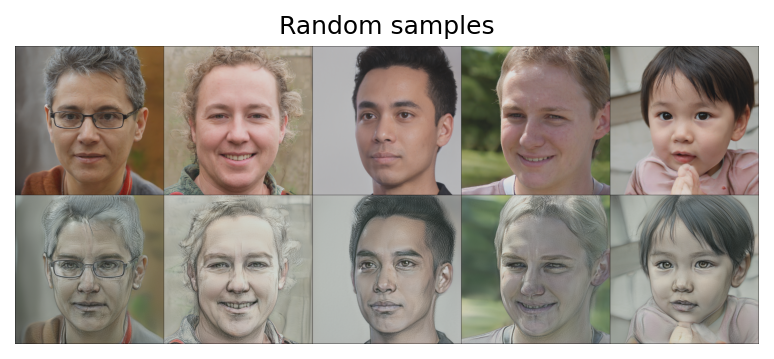

In [13]:
#@title Generate results
n_sample =  5#@param {type:"number"}
seed = 3000 #@param {type:"number"}

torch.manual_seed(seed)
with torch.no_grad():
    generator.eval()
    z = torch.randn(n_sample, latent_dim, device=device)

    original_sample = original_generator([z], truncation=0.7, truncation_latent=mean_latent)
    sample = generator([z], truncation=0.7, truncation_latent=mean_latent)

    original_my_sample = original_generator(my_w, input_is_latent=True)
    my_sample = generator(my_w, input_is_latent=True)

# display reference images
style_images = []
for name in names:
    style_path = f'style_images_aligned/{strip_path_extension(name)}.png'
    style_image = transform(Image.open(style_path))
    style_images.append(style_image)
    
face = transform(aligned_face).to(device).unsqueeze(0)
style_images = torch.stack(style_images, 0).to(device)
display_image(utils.make_grid(style_images, normalize=True, range=(-1, 1)), title='References')

my_output = torch.cat([face, my_sample], 0)
display_image(utils.make_grid(my_output, normalize=True, range=(-1, 1)), title='My sample')

output = torch.cat([original_sample, sample], 0)
display_image(utils.make_grid(output, normalize=True, range=(-1, 1), nrow=n_sample), title='Random samples')